<a href="https://colab.research.google.com/github/t-sasatani/clock_divide_select_4ch/blob/main/clock_divide_and_select_4ch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From code to silicon using XLS and OpenLane

```
Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

- Design your hardware with code using [XLS](https://google.github.io/xls/) high-level synthesis toolkit.
- Run your design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) RTL to GDS toolchain.
- Target the open source [SKY130](https://github.com/google/skywater-pdk/) PDK to manufacture your design using Google's sponsored [OpenMPW shuttle](https://developers.google.com/silicon) program.

In [1]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}
xls_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''
if xls_version == 'latest':
  xls_version = ''

import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version} \
                     xls={xls_version} \
                     iverilog
!python -m pip install cocotb pytest vcdvcd wavedrom
!curl -L -O https://patch-diff.githubusercontent.com/raw/The-OpenROAD-Project/OpenLane/pull/1503.patch
!patch -p1 -d conda-env/share/openlane < 1503.patch
!curl -L -O https://github.com/google/xls/archive/refs/heads/main.tar.gz
!tar --strip-components=1 -xf main.tar.gz xls-main/xls/dslx/stdlib/ xls-main/xls/modules/
def2gds_mag = '''gds read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
lef read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
lef read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
def read $::env(IN_DEF)
gds write $::env(IN_DEF).gds'''
with open('def2gds.mag', 'w') as f:
  f.write(def2gds_mag)
!git clone https://github.com/mbalestrini/GDS2glTF.git
!python -m pip install -r GDS2glTF/requirements.txt
!git clone https://github.com/proppy/gds_viewer.git
import jinja2
gds_viewer = jinja2.Environment(loader=jinja2.FileSystemLoader('gds_viewer')).get_template('viewer.html')

env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/


Pinned packages:
  - python 3.7*


Transaction

  Prefix: /content/conda-env


In [2]:
#@title Verilog
%%bash -c 'cat > user_module.v'

module user_module(
        input   wire    [26:0] io_in,
        output  wire    out
    );
    
    reg [6:0]   clock_counter_a     =   7'b0000000;
    reg [6:0]   clock_counter_b     =   7'b0000000;
    reg [6:0]   clock_counter_c     =   7'b0000000;
    reg [6:0]   clock_counter_d     =   7'b0000000;
    reg [3:0]   div_clock         =   4'b0000;

    wire [5:0]  clock_div_factor_a;
    wire [5:0]  clock_div_factor_b;
    wire [5:0]  clock_div_factor_c;
    wire [5:0]  clock_div_factor_d;
    wire [1:0]  clock_select;
    wire        clk;
    wire        clock_syn;
    
    assign  clk = io_in[0];
    assign  clock_select = io_in[2:1];
    assign  clock_syn = div_clock[clock_select];
    assign  clock_div_factor_a = io_in[8:3];
    assign  clock_div_factor_b = io_in[14:9];
    assign  clock_div_factor_c = io_in[20:15];
    assign  clock_div_factor_d = io_in[26:21];
    
    
    always @ (posedge clk) begin
        clock_counter_a <= clock_counter_a + 1;
        clock_counter_b <= clock_counter_b + 1;
        clock_counter_c <= clock_counter_c + 1;
        clock_counter_d <= clock_counter_d + 1;

        if (clock_div_factor_a < clock_counter_a) begin
            div_clock[0] <= ~div_clock[0];
            clock_counter_a <= 7'b0000000;
        end
        if (clock_div_factor_b < clock_counter_b) begin
            div_clock[1] <= ~div_clock[1];
            clock_counter_b <= 7'b0000000;
        end
        if (clock_div_factor_c < clock_counter_c) begin
            div_clock[2] <= ~div_clock[2];
            clock_counter_c <= 7'b0000000;
        end
        if (clock_div_factor_d < clock_counter_d) begin
            div_clock[3] <= ~div_clock[3];
            clock_counter_d <= 7'b0000000;
        end
    end
    
    assign out = clock_syn;
endmodule

In [3]:
%%writefile pin_order.cfg
#BUS_SORT

#W
io_in.*

#E
out.*

Overwriting pin_order.cfg


In [4]:
#@title config.json
%%writefile config.json
{
    "DESIGN_NAME": "user_module",
    "VERILOG_FILES": "dir::user_module.v",
    "CLOCK_TREE_SYNTH": true,
    "CLOCK_PERIOD": 50,
    "CLOCK_PORT": "io_in[0]",
    "CLOCK_NET": "io_in[0]",
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 100 100",
    "PL_TARGET_DENSITY": 0.70,
    "FP_PIN_ORDER_CFG": "dir::pin_order.cfg"
}

Overwriting config.json


In [5]:
#@title Synthesis
%env PDK=sky130A
!flow.tcl -design . -to synthesis

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 3696eca015bc64afa69c385dddaae931d9da3496, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: be40825e9aadc1bed858801572bef0415444b516, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

[PosixPath('runs/RUN_2022.12.29_15.26.45/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_15.28.58/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_15.30.45/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_15.31.56/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_16.22.17/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_16.23.22/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.31.42/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.33.06/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.36.15/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.37.10/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.38.15/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.40.33/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.40.45/tmp/synthesis/post_techmap.dot'), PosixPath('runs/RUN_2022.12.29_17.42.

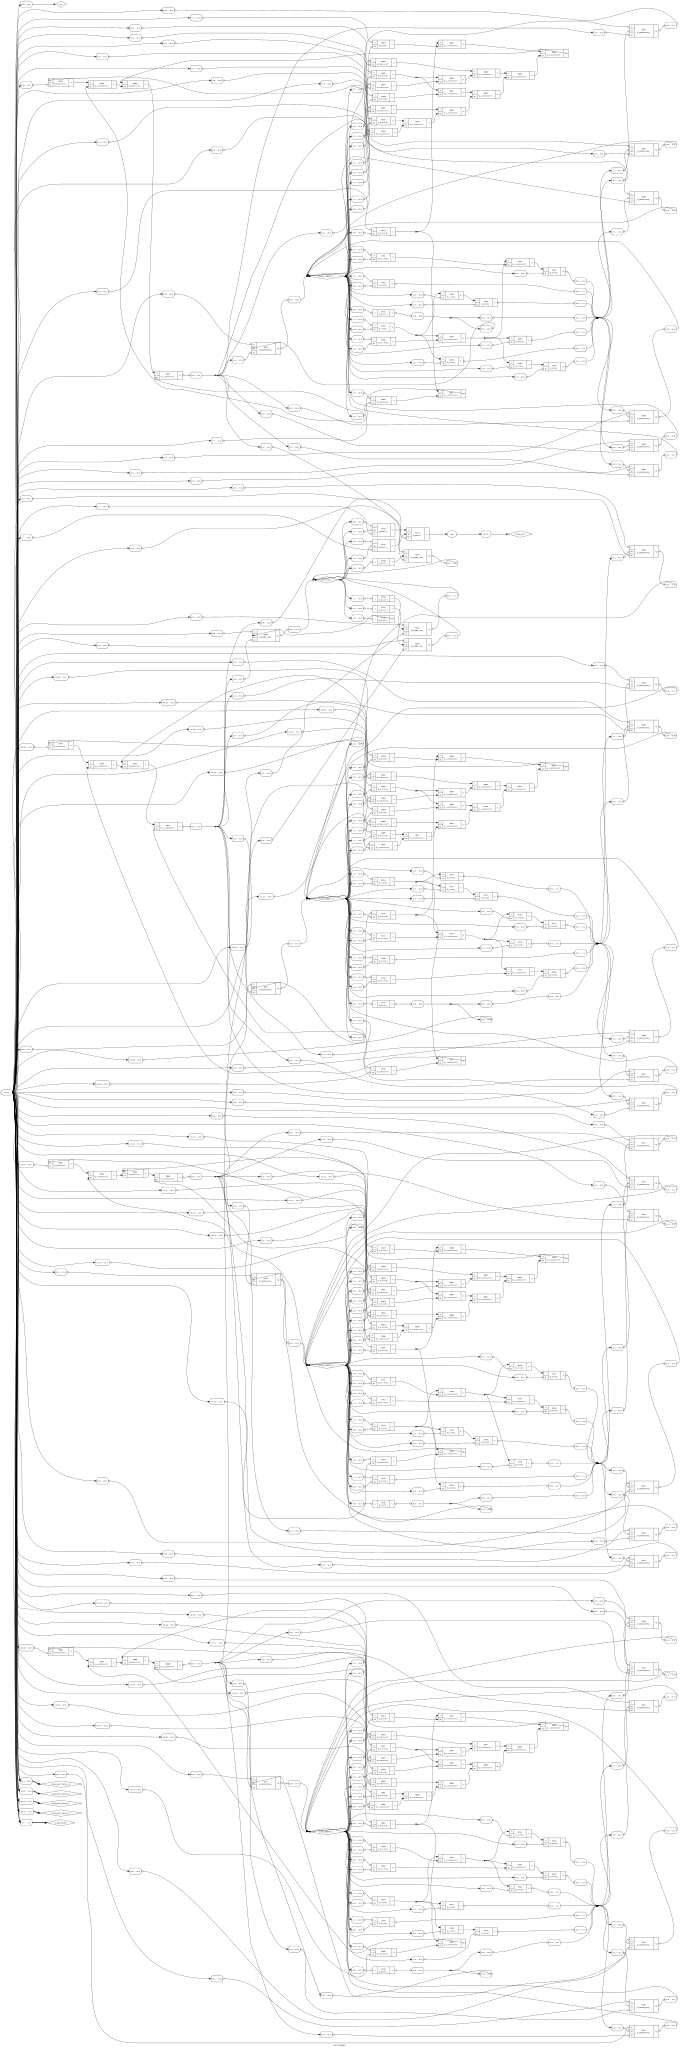

In [6]:
#@title Preview

import graphviz
import pathlib

dots = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
print(dots)
dot = graphviz.Source.from_file(dots[-1])
dot.engine = 'dot'
dot

In [7]:
#@title Openlane
%env PDK=sky130A
!flow.tcl -design . -verbose 10 -to cts

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 3696eca015bc64afa69c385dddaae931d9da3496, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: be40825e9aadc1bed858801572bef0415444b516, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

In [8]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: 3696eca015bc64afa69c385dddaae931d9da3496, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: be40825e9aadc1bed858801572bef0415444b516, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

In [9]:
#@title Metrics {display-mode: "form"}
import pathlib
import pandas as pd

pd.options.display.max_rows = None
csv = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(csv[-1])
df.transpose()

0
design                                     /content
design_name                             user_module
config                      RUN_2022.12.29_19.31.30
flow_status                          flow completed
total_runtime                            0h1m46s0ms
routed_runtime                           0h1m30s0ms
(Cell/mm^2)/Core_Util                       37200.0
DIEAREA_mm^2                                   0.01
CellPer_mm^2                                18600.0
OpenDP_Util                                   28.31
Peak_Memory_Usage_MB                         488.38
cell_count                                      186
tritonRoute_violations                            0
Short_violations                                  0
MetSpc_violations                                 0
OffGrid_violations                                0
MinHole_violations                                0
Other_violations                                  0
Magic_violations                                  0
antenna_violations                               -1
lvs_total_errors                                 -1
cvc_total_errors                                 -1
klayout_violations                               -1
wire_length                                    6856
vias                                           1584
wns                                             0.0
pl_wns                                          0.0
optimized_wns                                   0.0
fastroute_wns                                   0.0
spef_wns                                        0.0
tns                                             0.0
pl_tns                                          0.0
optimized_tns                                   0.0
fastroute_tns                                   0.0
spef_tns                                        0.0
HPWL                                      1851153.0
routing_layer1_pct                              0.0
routing_layer2_pct                            22.74
routing_layer3_pct                             14.0
routing_layer4_pct                             4.44
routing_layer5_pct                              0.0
routing_layer6_pct                              0.0
wires_count                                     152
wire_bits                                       298
public_wires_count                               14
public_wire_bits                                 88
memories_count                                    0
memory_bits                                       0
processes_count                                   0
cells_pre_abc                                   191
AND                                              12
DFF                                               0
NAND                                              8
NOR                                               0
OR                                                0
XOR                                              32
XNOR                                             12
MUX                                               3
inputs                                           58
outputs                                          33
level                                             6
EndCaps                                          56
TapCells                                         90
Diodes                                            0
Total_Physical_Cells                            146
CoreArea_um^2                             6761.4848
power_slowest_internal_uW                        -1
power_slowest_switching_uW                       -1
power_slowest_leakage_uW                         -1
power_typical_internal_uW                        -1
power_typical_switching_uW                       -1
power_typical_leakage_uW                         -1
power_fastest_internal_uW                        -1
power_fastest_switching_uW                       -1
power_fastest_leakage_uW                         -1
critical_path_ns                                 -1
suggested_clock_period                        

In [10]:
#@title Preview {display-mode: "form"}

import pathlib

gds = sorted(pathlib.Path('runs').glob(f'*/results/final/gds/*.gds'))[-1].resolve()
!python3 GDS2glTF/gds2gltf.py {gds} | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{gds}.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

# Tape-out

In order to onboard on the Google's sponsored [OpenMPW shuttle program](https://developers.google.com/silicon), your design needs to be integrated in the [Caravel SoC harness](https://caravel-harness.readthedocs.io/) using the [Caravel User Project](https://caravel-user-project.readthedocs.io/en/latest/) template and pass the [mpw pre-check](https://github.com/efabless/mpw_precheck) tests.

![caravel](https://caravel-user-project.readthedocs.io/en/latest/_static/layout.png)

- User project area: 2920 µm x 3520 µm
- SoC: RISC-V based ([specs](https://caravel-mgmt-soc-litex.readthedocs.io/en/latest/#features))
- I/O pins: 38 ([pinout](https://caravel-harness.readthedocs.io/en/latest/pinout.html))
- Communication: Wishbone bus and 128 logic analyser pins


## Submit your design with `tiny_user_project`

1. Create a new GitHub project using the [tiny_user_project template](https://github.com/proppy/tiny_user_project).
1. [Set GitHub Pages](https://tinytapeout.com/faq/#my-github-action-is-failing-on-the-pages-part) `Sources` as `GitHub Actions`
1. Update `verilog/rtl/user_module.v` with the generated verilog for your design.
1. Update `info.yaml` to match your project:
   - set `wokwi_id` to `0`
   - uncomment and set `source_files` to `- verilog/rtl/user_module.v`.
   - uncomment and set `top_module` to `user_module`.
   - update the `documentation` and the `inputs` / `outputs` mapping to match your projects.
1. Commit, push and check the `Actions` summary for the  ![user_project_ci](https://github.com/proppy/tiny_caravel_user_project/actions/workflows/user_project_ci.yml/badge.svg) workflow (if successful a new commit including the hardened files will be automatically created).
1. [Submit](https://platform.efabless.com/projects/create?project_definition=Open+MPW&shuttle=MPW-8) your project github repository to the next [Open MPW shuttle](https://platform.efabless.com/shuttles/MPW-8).

# New Section